# CHEM277B Homework 4
### Trevor Oldham
### February 2023

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib notebook

# Problem 1
### (A)

In [2]:
data=pd.read_csv("Admission_Predict_Ver1.1.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


The following fields in the dataframe are the features which affect the chance of admission to graduate school:

GRE Score - (Scored out of 340)

TOEFL Score - Test of English as a Foreign Language - (scored out of 120)

University Rating - (scored out of 5)

SOP - Statement of Purpose (scored out of 5.0)

LOR - Letters of Recommendations (scored out of 5.0)

CGPA - Cumulative Grade Point Average (scored out of 10.00)

Research - (scored 1 for Yes, 0 for No)

In [3]:
#normalizing the features in the dataframe
features=data.drop(['Serial No.', 'Chance of Admit '], axis=1)
chances=data['Chance of Admit ']
chances = (chances - chances.mean())/chances.std()
chances = chances.values
features_norm = (features - features.mean())/features.std()
features_norm.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,1.817417,1.777086,0.774806,1.136222,1.097845,1.775029,0.885518
1,0.666481,-0.031569,0.774806,0.631683,1.097845,0.485373,0.885518
2,-0.041788,-0.524839,-0.099693,-0.377395,0.017289,-0.953088,0.885518
3,0.489414,0.461700,-0.099693,0.127144,-1.063267,0.154692,0.885518
4,-0.218855,-0.689262,-0.974192,-1.386473,-0.522989,-0.605873,-1.127023


### (B)

The code for a simple perceptron is below, in which I added code for the 'init()' function to initialize weights to random numbers between 0 and 0.05. I added code in predict() function to calculate the weighted sums and the activations from a given X. I added code in fit() to adjust the weights based on the gradient of the weights and the learning rate. The evaluate() function now returns the Mean Squared Error between a list of observations y and the activations from the output neurons. This constructor can be initialized with any number of inputs and outputs, and the functions fit() and predict() can take a list of any number of input examples as a list of rows. 

In [4]:
class simple_perceptron():
    def __init__(self,input_dim,output_dim,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1):
        
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.activation=activation
        self.activation_grad=activation_grad
        self.lr=learning_rate
        ### initialize parameters ###
        self.weights= np.random.uniform(low=0, high=0.05, size=(output_dim, input_dim))
        self.biases= np.random.uniform(low=0, high=0.05, size=(output_dim))

    def predict(self,X):
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        dim=X.shape[1]
        # Check that the dimension of accepted input data is the same as expected
        if not dim==self.input_dim:
            raise Exception("Expected input size %d, accepted %d!"%(self.input_dim,dim))
        ### Calculate logit and activation ###
        self.z = X.dot(self.weights.T) + self.biases       #shape(X.shape[0],1)
        self.a = np.array(self.activation(self.z))            #shape(X.shape[0],1)
        return self.a
    
    def fit(self,X,y):
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        self.predict(X)
        errors=(self.a-y)*self.activation_grad(self.z)
        weights_grad=errors.T.dot(X)
        bias_grad=np.sum(errors,axis=0)
        ### Update weights and biases from the gradient ###
        self.weights = self.weights - (self.lr * weights_grad)
        self.biases -= self.lr * bias_grad

        
    def train_on_epoch(self,X,y,batch_size=32):
        # Every time select batch_size samples from the training set, until all data in the training set has been trained once
        order=list(range(X.shape[0]))
        np.random.shuffle(order)
        n=0
        while n<math.ceil(len(order)/batch_size)-1: # Parts that can fill one batch
            self.fit(X[order[n*batch_size:(n+1)*batch_size]],y[order[n*batch_size:(n+1)*batch_size]])
            n+=1
        # Parts that cannot fill one batch
        self.fit(X[order[n*batch_size:]],y[order[n*batch_size:]])
        
    def evaluate(self,X,y):
         # Transform the single-sample data into 2-dimensional
        if len(X.shape)==1:
            X=X.reshape((1,-1))
        if len(y.shape)==1:
            y=y.reshape((1,-1))
        ### means square error ###
        y_hat = self.predict(X)
        return (1/(y.shape[0])) * np.sum((y - y_hat)**2)
    
    def get_weights(self):
        return (self.weights,self.biases)
    
    def set_weights(self,weights):
        self.weights=weights[0]
        self.biases=weights[1]

I created a simple perceptron with an input dimension of 3 and and output dimension of 2. Then I created two examples to demonstrate the fit(), predict(), and evaluate() functions. These functions also work on lists of data, and returns lists for the corresponding y prediction or evaluation.

In [5]:
s = simple_perceptron(input_dim=3,output_dim=2,learning_rate=0.01,activation=lambda x:x,activation_grad=lambda x:1)

In [6]:
np.random.seed(0)
X = np.zeros(3)
y = np.zeros(2)
print('Prediction of X : ', s.predict(X))
print('Shape of predicted Y : ', s.predict(X).shape)
print("Testing s.fit and s.evaluate : ")
s.fit(X, y)
s.evaluate(X, y)

Prediction of X :  [[0.01819163 0.01341572]]
Shape of predicted Y :  (1, 2)
Testing s.fit and s.evaluate : 


0.0005007497971149362

In [7]:
X = np.array([[0, 1, 1], [1, 1, 0]])
print("X shape : ", X.shape)
print('Prediction of X : ', s.predict(X))
print('Shape of predicted Y : ', s.predict(X).shape)
y = np.array([[0.5, 0.5], [1, 0.5]])
print("Testing s.fit and s.evaluate : ")
s.fit(X, y)
s.evaluate(X, y)

X shape :  (2, 3)
Prediction of X :  [[0.0515263  0.0911318 ]
 [0.06843325 0.08623176]]
Shape of predicted Y :  (2, 2)
Testing s.fit and s.evaluate : 


0.6395823526775908

In [8]:
#s = simple_perceptron(input_dim=7,output_dim=1,learning_rate=0.0001,activation=lambda x:x,activation_grad=lambda x:1)
#scaler = StandardScaler()
#X = scaler.fit_transform(features_norm)
#print('X shape: ', X.shape)
#y = chances.reshape(-1, 1)
#print('y shape: ', y.shape)
#print('Prediction given X : ', s.predict(X))
#print('Shape of predicted Y : ', s.predict(X).shape)
#print("Testing s.fit and s.evaluate : ")
#s.fit(X, y)
#s.evaluate(X, y)

### (C)

In [9]:
def Kfold(k,Xs,ys,epochs,learning_rate=0.0001,draw_curve=True):
    # The total number of examples for training the network
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= Xs[train_selector]
        test_Xs=  Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, train_size = 0.8)
        
        ### Establish the model for simple perceptron here ###
        model = simple_perceptron(input_dim=Xs.shape[1],output_dim=ys.shape[1],learning_rate=0.0001,activation=lambda x:x,activation_grad=lambda x:1)
        
        # Save the lowest weights, so that we can recover the best model
        weights = model.get_weights()
        lowest_val_err = np.inf
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_on_epoch(train_in,train_real)
            val_err = model.evaluate(val_in,val_real)
            val_array.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        final_epochs=np.argmin(val_array)
        print("Number of epochs with lowest validation:",final_epochs)
        # Recover the model weight
        model.set_weights(weights)

        # Report result for this fold
        train_error=model.evaluate(train_Xs,train_ys)
        train_error_all.append(train_error)
        test_error= model.evaluate(test_Xs,test_ys)
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model


The k-fold function has been completed and will next be used to run a 5-fold validation on the model, based on the normalized features and the normalized chance of admit.

feats shape:  (500, 7)
outputs shape:  (500, 1)
Number of epochs with lowest validation: 78
Train error: 0.18058808300052964
Test error: 0.2176355662836098


<IPython.core.display.Javascript object>


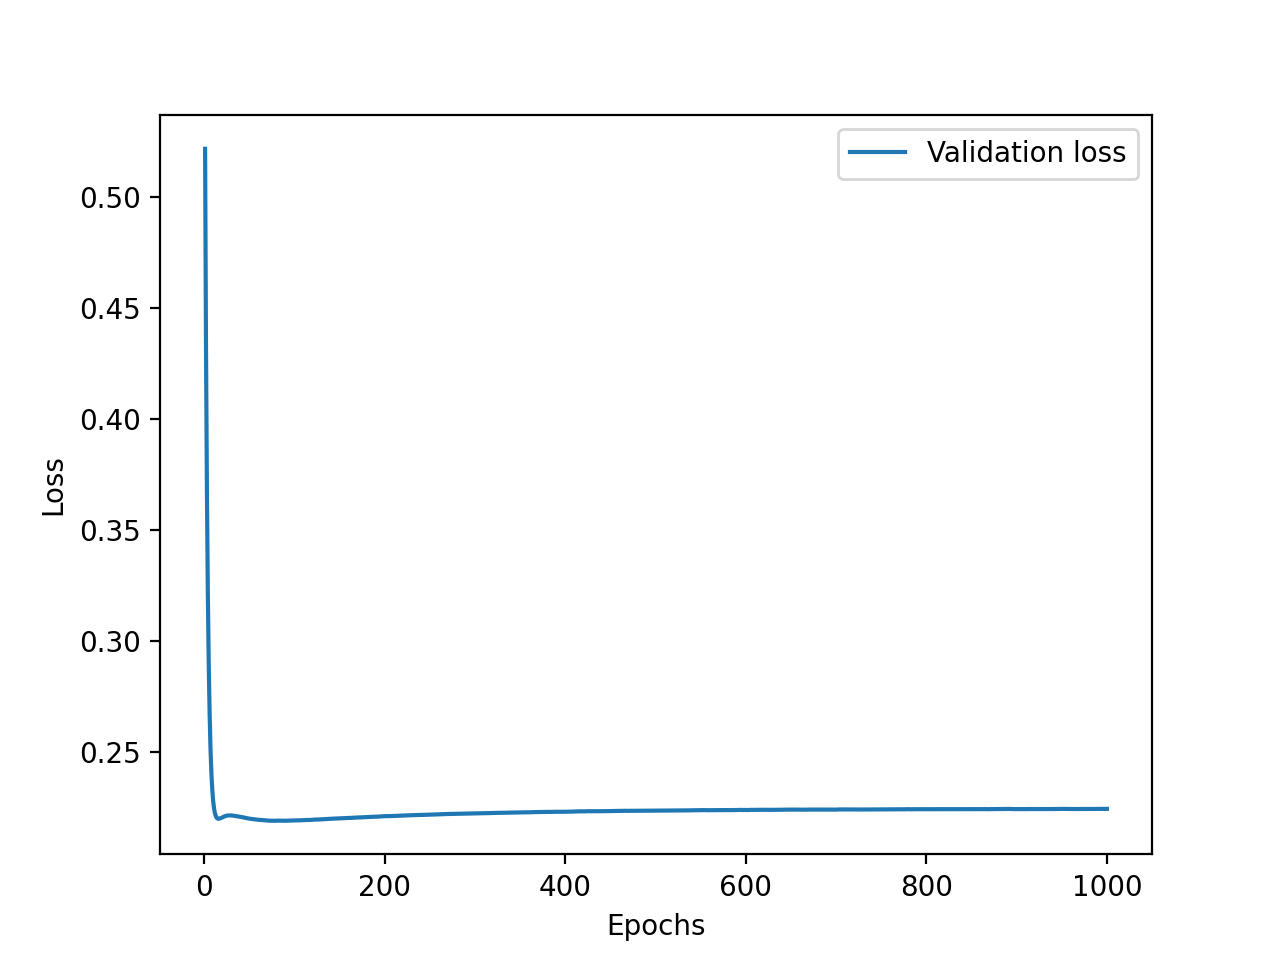

Number of epochs with lowest validation: 997
Train error: 0.17269774001449265
Test error: 0.19978607719650587


<IPython.core.display.Javascript object>


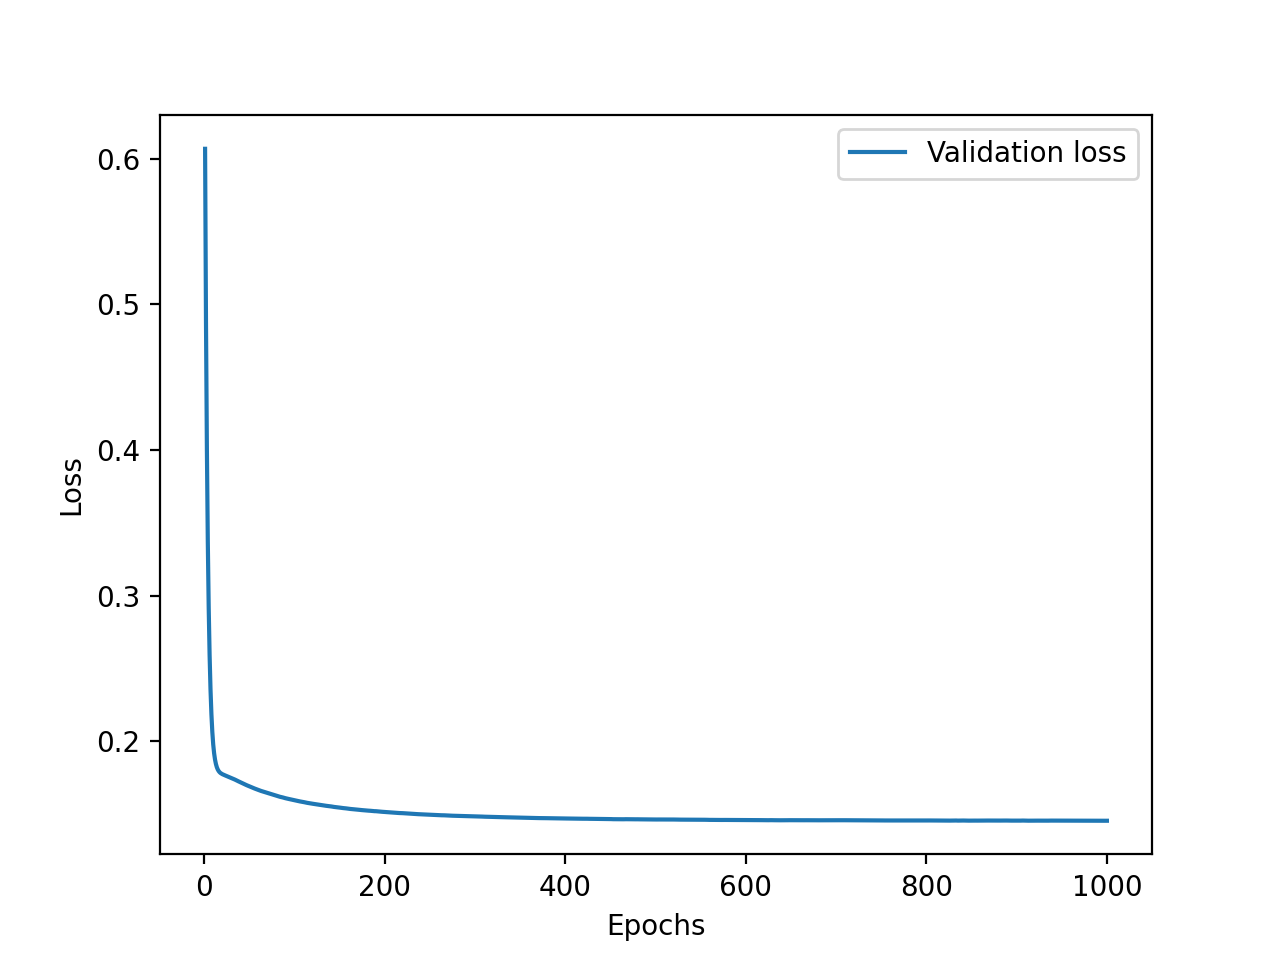

Number of epochs with lowest validation: 994
Train error: 0.18484105552598912
Test error: 0.15835254065982635


<IPython.core.display.Javascript object>


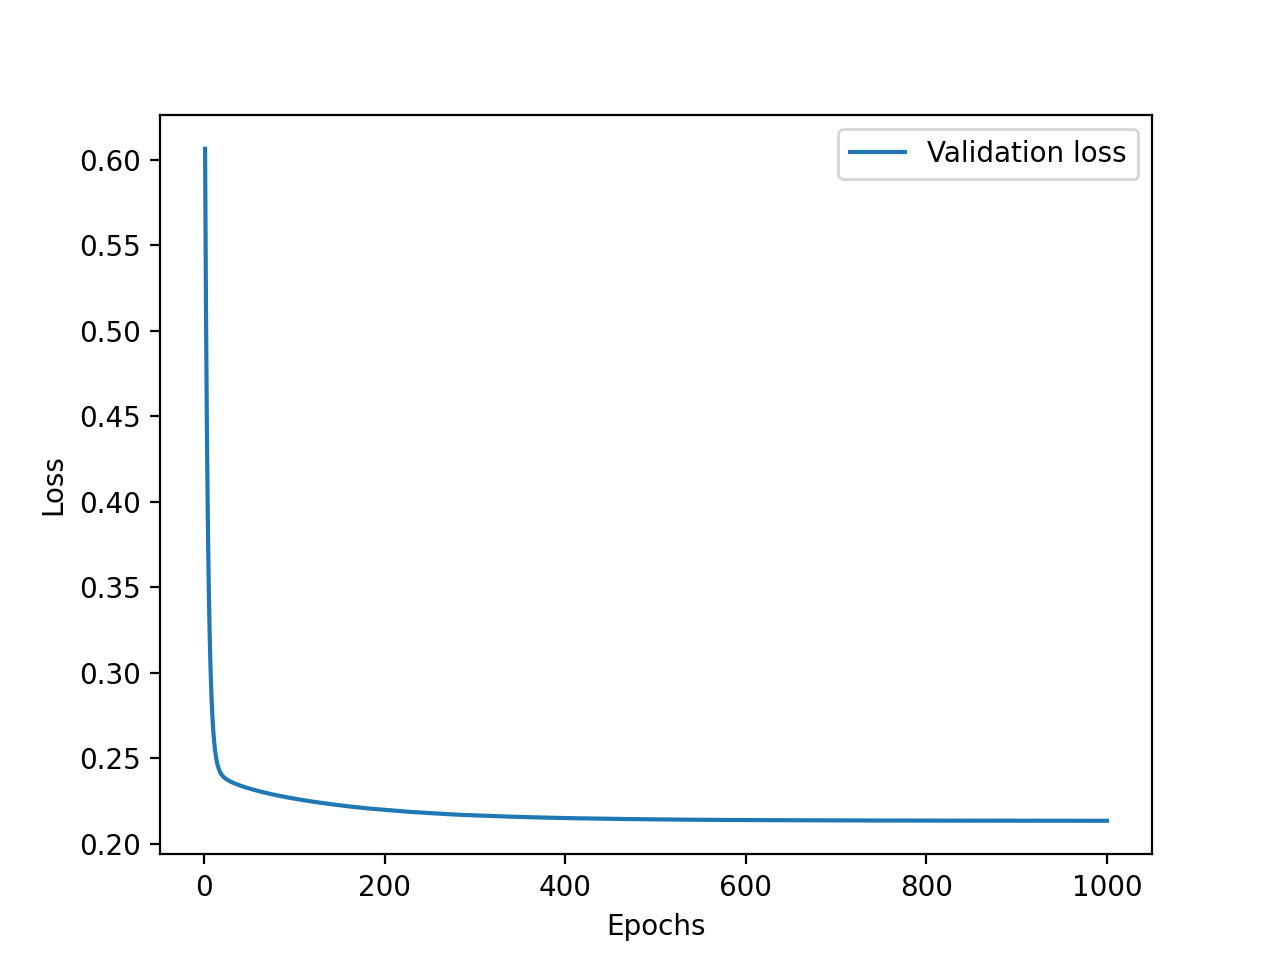

Number of epochs with lowest validation: 12
Train error: 0.21473316126839984
Test error: 0.19566386083132664


<IPython.core.display.Javascript object>


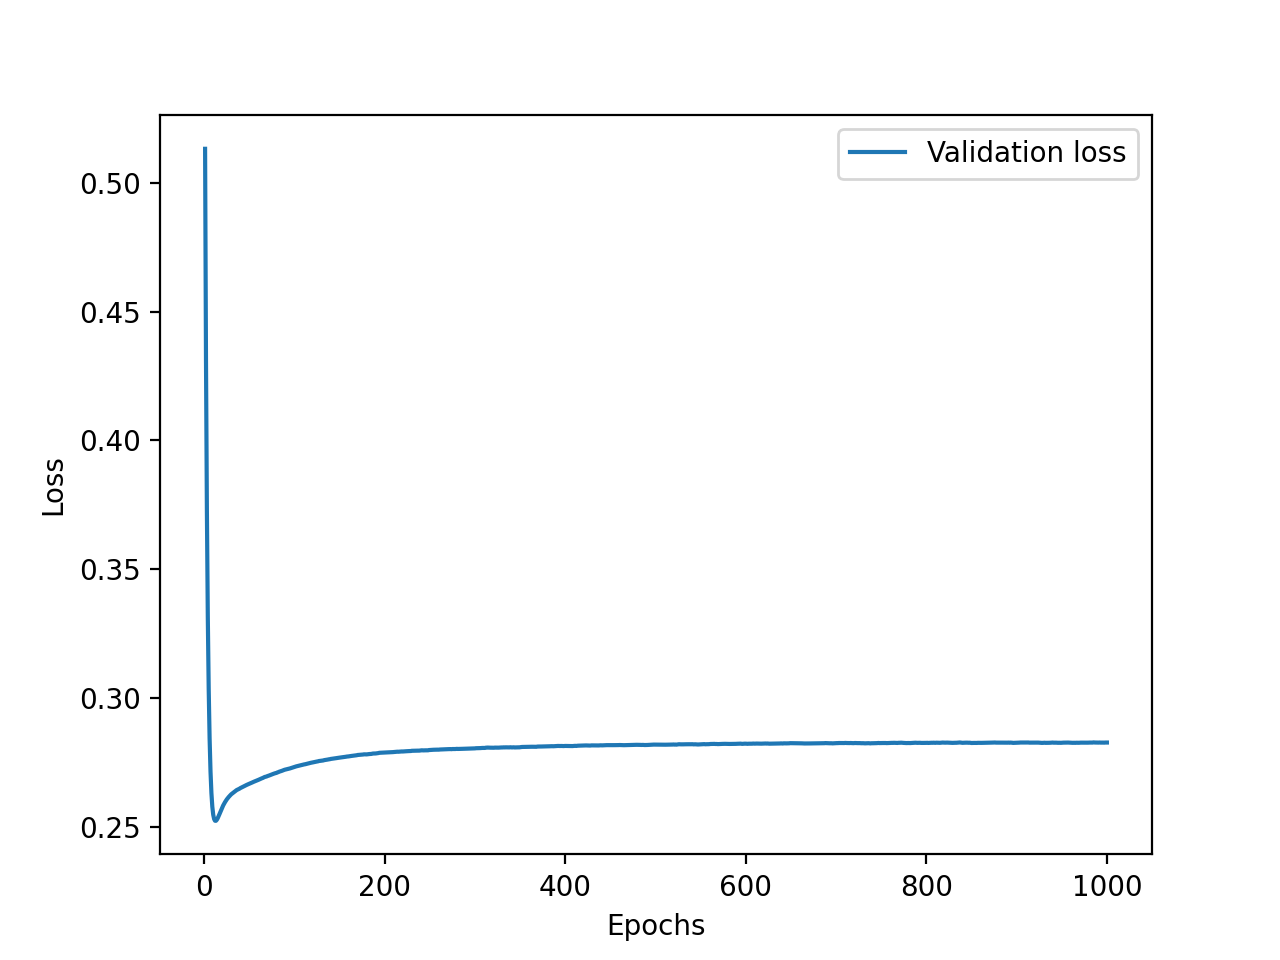

Number of epochs with lowest validation: 474
Train error: 0.1756870099355516
Test error: 0.18717272383176448


<IPython.core.display.Javascript object>


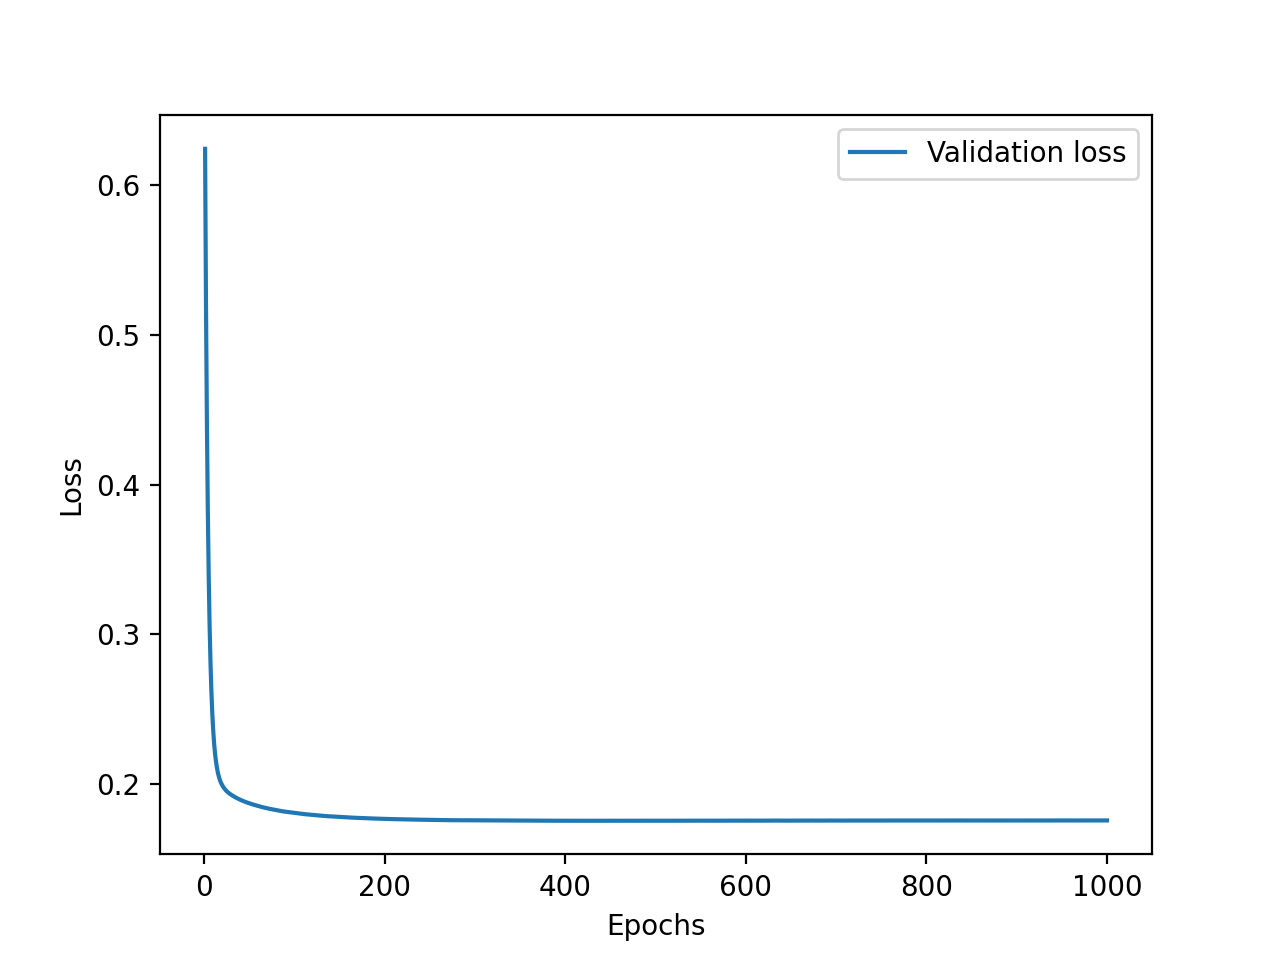

Final results:
Training error:0.185709+-0.015094
Testing error:0.191722+-0.019423


In [10]:
scaler = StandardScaler()
feats = scaler.fit_transform(features_norm)
print('feats shape: ', feats.shape)
outputs = chances.reshape(-1, 1)
print('outputs shape: ', outputs.shape)

Kfold(5,feats,outputs,epochs=1000,learning_rate=0.0001,draw_curve=True)

After running the simulation with the features data from graduate admissions, we show the five-fold cross validation results. As the number of epochs increase, the model becomes better trained and the mean squared error is minimized, so the Chance of Admit column is predicted the best after more epochs used to train it. The final results suggest that once the model is trained, the training error rate is 0.189 and the testing error is 0.187, so that means the model performs just as well on training data as it does with new data. This means the seven features are a good indicator of the chance of admission. This model does not predict a yes or no value but rather computes the percentage chance of admission by finding the minimal least squares error among by varying the weights and the biases of the simple perceptron.

Next we drop the column labeled 'GRE Score' to see what changes will result in the model, to better understand how impactful the GRE score is when used as a feature for the perceptron.

In [11]:
features_norm = (features - features.mean())/features.std()
features_norm.drop(['GRE Score'], axis = 1)

scaler = StandardScaler()
feats = scaler.fit_transform(features_norm)
print('feats shape: ', feats.shape)
outputs = chances.reshape(-1, 1)
print('outputs shape: ', outputs.shape)

Kfold(5,feats,outputs,epochs=1000,learning_rate=0.0001,draw_curve=False)

feats shape:  (500, 7)
outputs shape:  (500, 1)
Number of epochs with lowest validation: 992
Train error: 0.18324063967264728
Test error: 0.1583463788433247
Number of epochs with lowest validation: 69
Train error: 0.16152436663413158
Test error: 0.2901149262677022
Number of epochs with lowest validation: 954
Train error: 0.1796374506384979
Test error: 0.175248578181833
Number of epochs with lowest validation: 804
Train error: 0.17560714367655944
Test error: 0.19320511568951393
Number of epochs with lowest validation: 158
Train error: 0.20164073117886358
Test error: 0.10657373667181745
Final results:
Training error:0.180330+-0.012954
Testing error:0.184698+-0.060120


With the GRE scores removed, the model still has a training error of roughly the same, so we conclude that the GRE Score is not necessary to predict the chance of admit. I could imagine that the same would be true of any other column too if we had dropped any feature, because there are still six other indicators.

# Problem 2
### (A)


The data from the Titanic census is read into a pandas dataframe. This dataset contains categorical features as well as continuous features, and the output that we want to predict (survived) is categorical as well. The continuous features I chose are SibSp, Parch, PassengerId, Age, Ticket, and Fare. I chose PassengerId because the value of that field could have some effect on the prediction, like lower or higher PassengerId. I chose Cabin to be a categorical feature because it probably has repeat values and can't be sorted with the letters that precede the number.

In [12]:
data=pd.read_csv("titanic.csv")
data = data.dropna(axis = 0, how='any')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [13]:
continuous_features = data[['SibSp', 'Parch', 'PassengerId', 'Age', 'Fare']]
categorical_features = data[['Pclass', 'Sex', 'Cabin', 'Embarked']]
output = data[['Survived']]

We use one-hot-encoding from sklearn to transform the catgorical features and the predicted output (Survived). The continuous values are also normalized.

In [14]:
continuous_features = (continuous_features - continuous_features.mean())/continuous_features.std()
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(categorical_features)
input_cate_feats = encoder.transform(categorical_features).toarray()

feats = np.hstack((continuous_features, input_cate_feats))
print(feats.shape)



output_encoder=OneHotEncoder()
y = np.array(output).reshape(-1,1)
output_encoder.fit(y)
y_encoded = output_encoder.transform(y).toarray()
y_encoded.shape

(183, 146)


(183, 2)

### (B)
We now use the KFold() function to input the features array into a simple perceptron model and predict the survivability of the passengers.

Number of epochs with lowest validation: 483
Train error: 0.2653726713951421
Test error: 0.29705656421897647


<IPython.core.display.Javascript object>


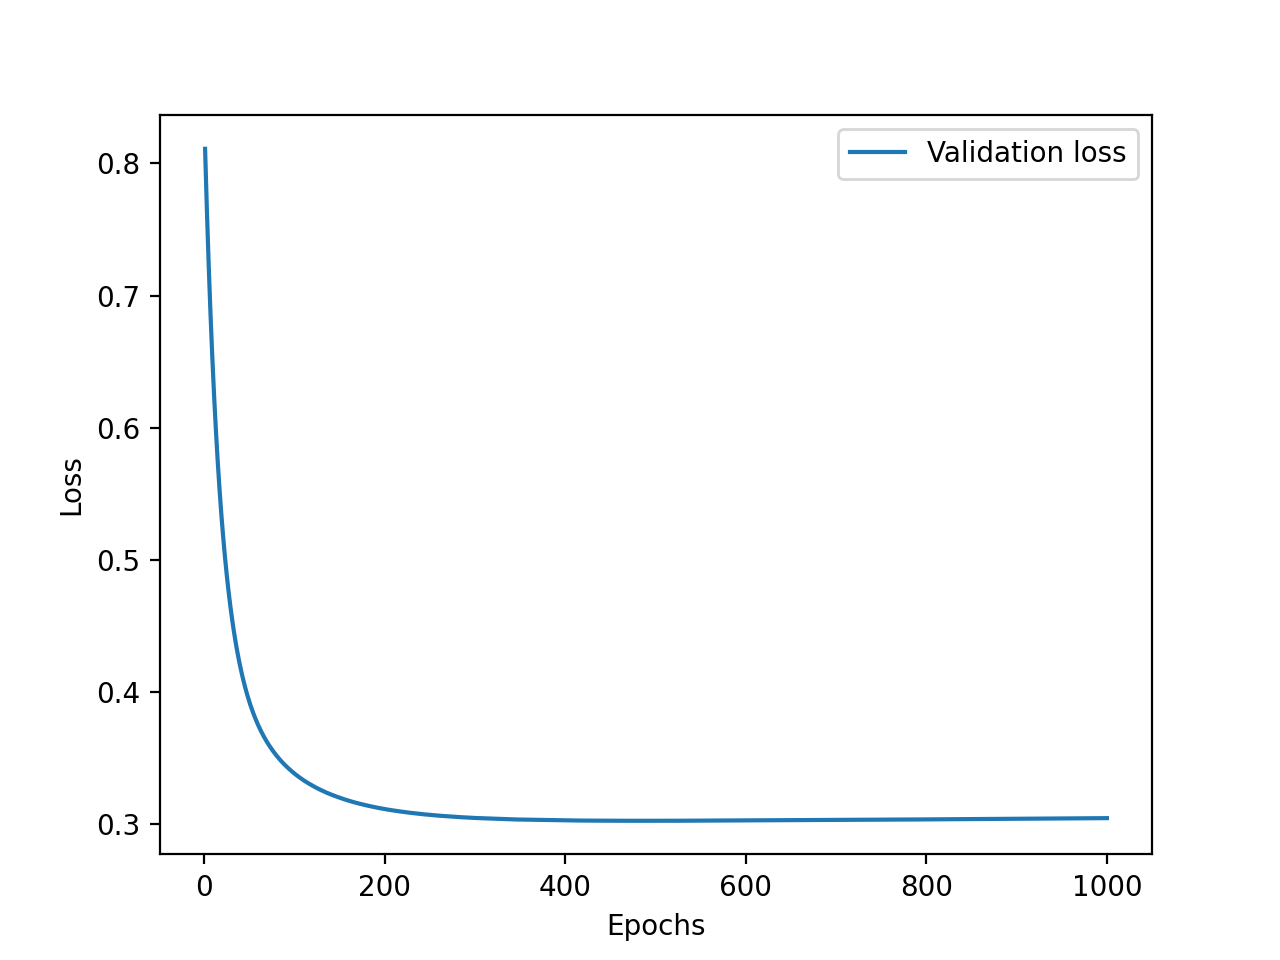

Number of epochs with lowest validation: 275
Train error: 0.29767833262925225
Test error: 0.2521101463488228


<IPython.core.display.Javascript object>


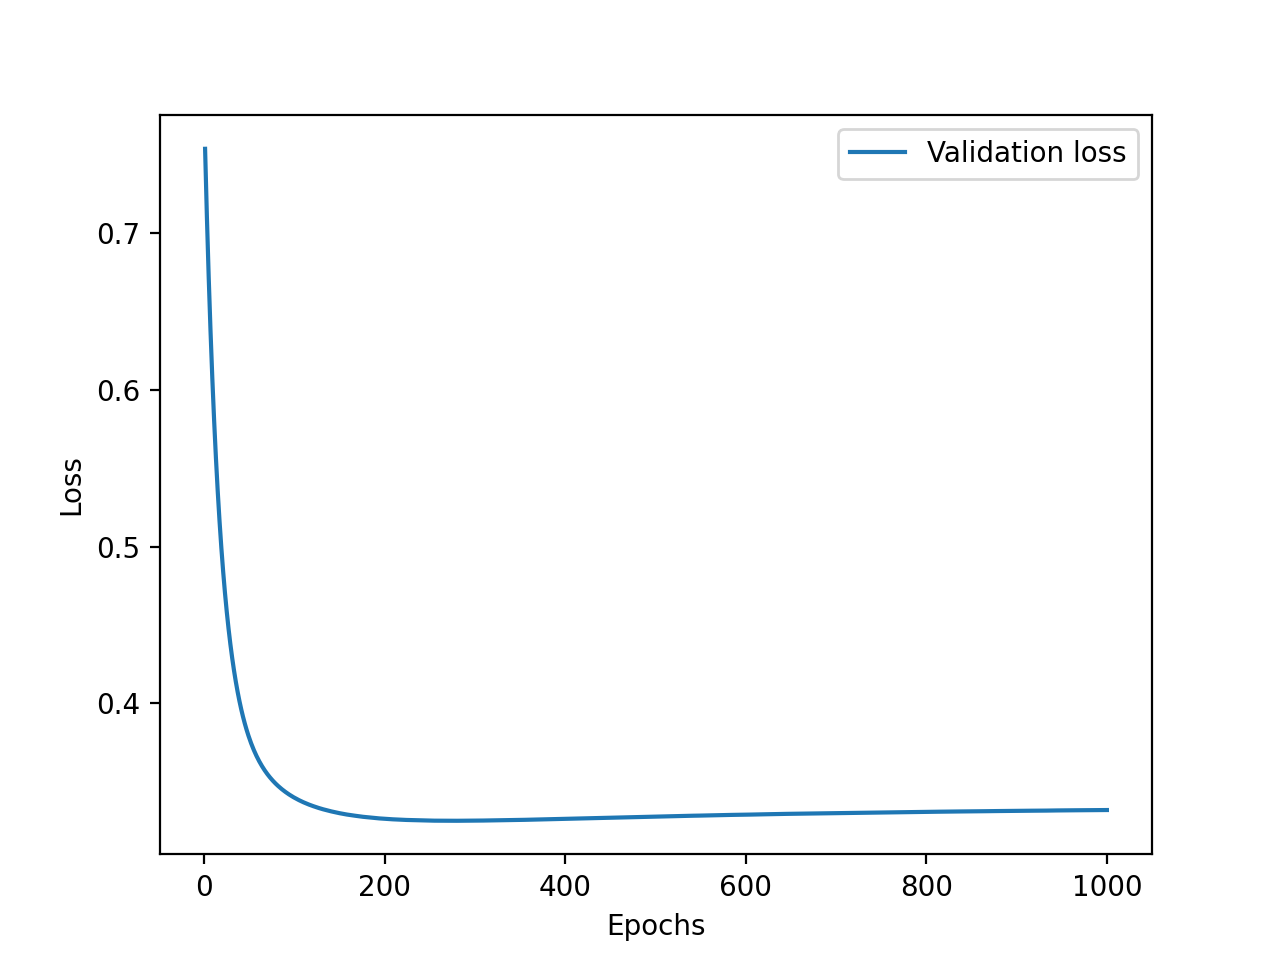

Number of epochs with lowest validation: 445
Train error: 0.2652241866492537
Test error: 0.3041706194151667


<IPython.core.display.Javascript object>


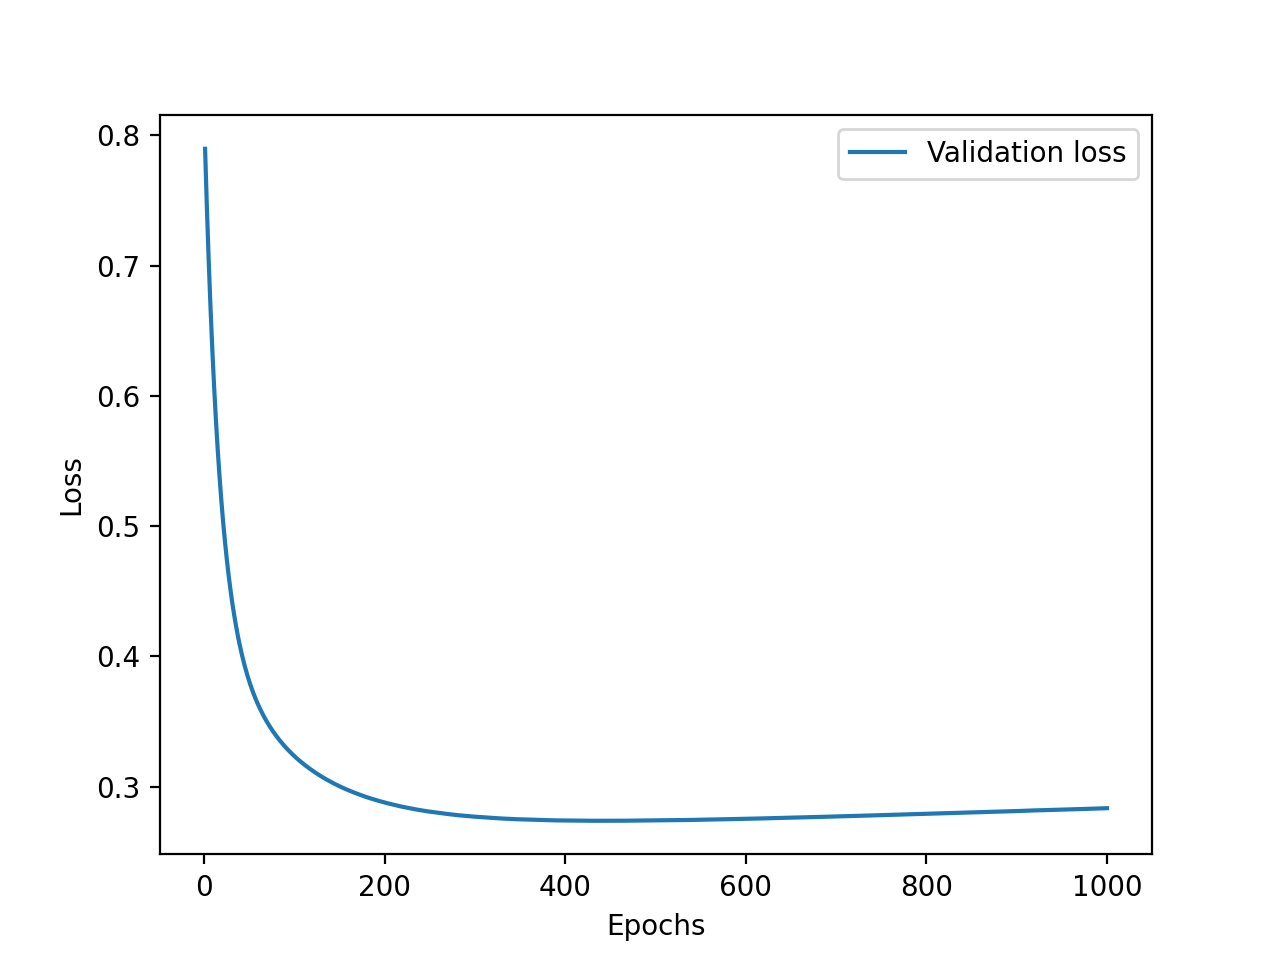

Number of epochs with lowest validation: 999
Train error: 0.23665913699149843
Test error: 0.3723829045230906


<IPython.core.display.Javascript object>


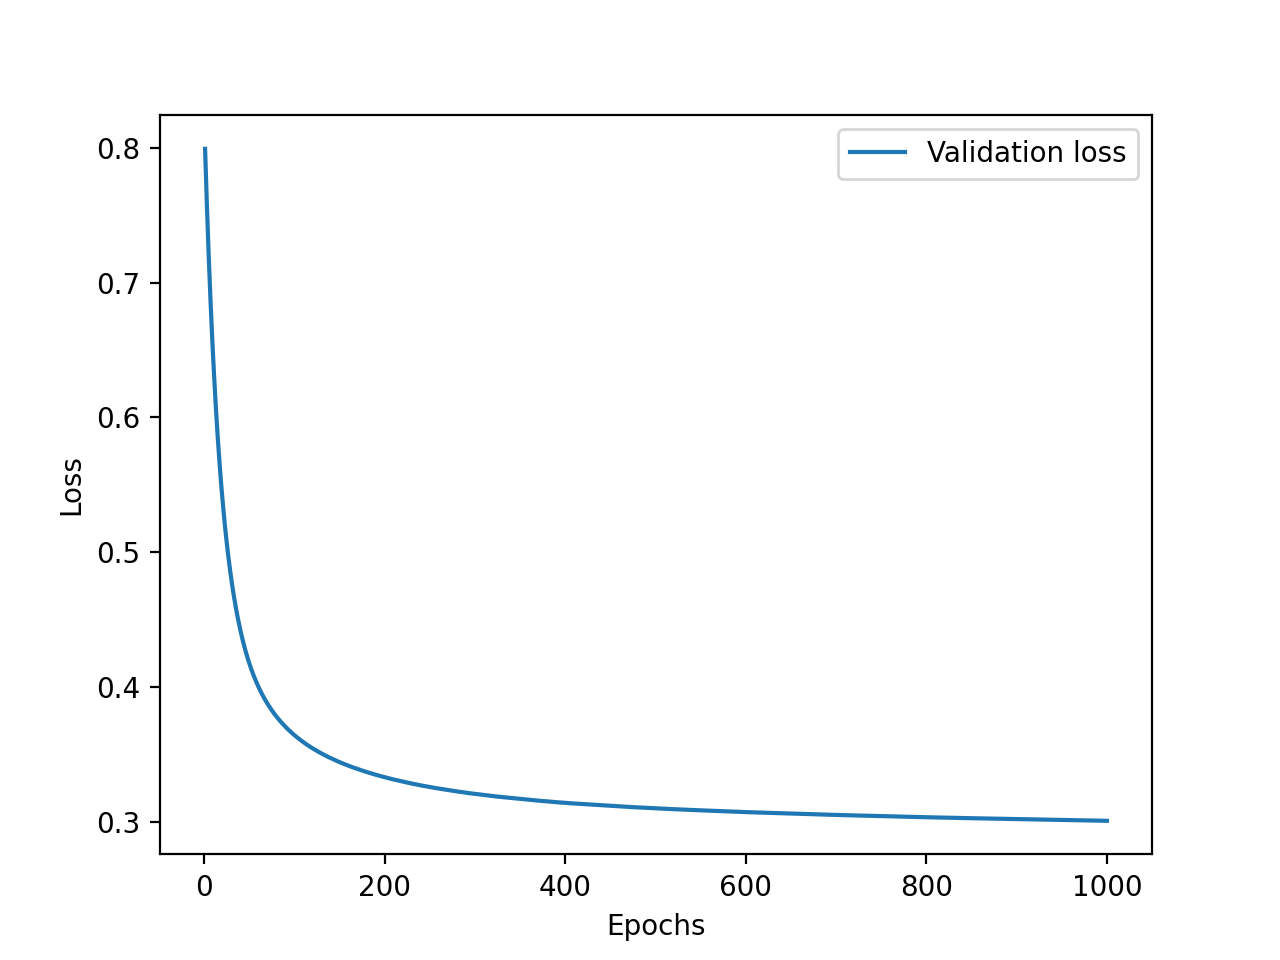

Number of epochs with lowest validation: 115
Train error: 0.2947808651892689
Test error: 0.38735636335601864


<IPython.core.display.Javascript object>


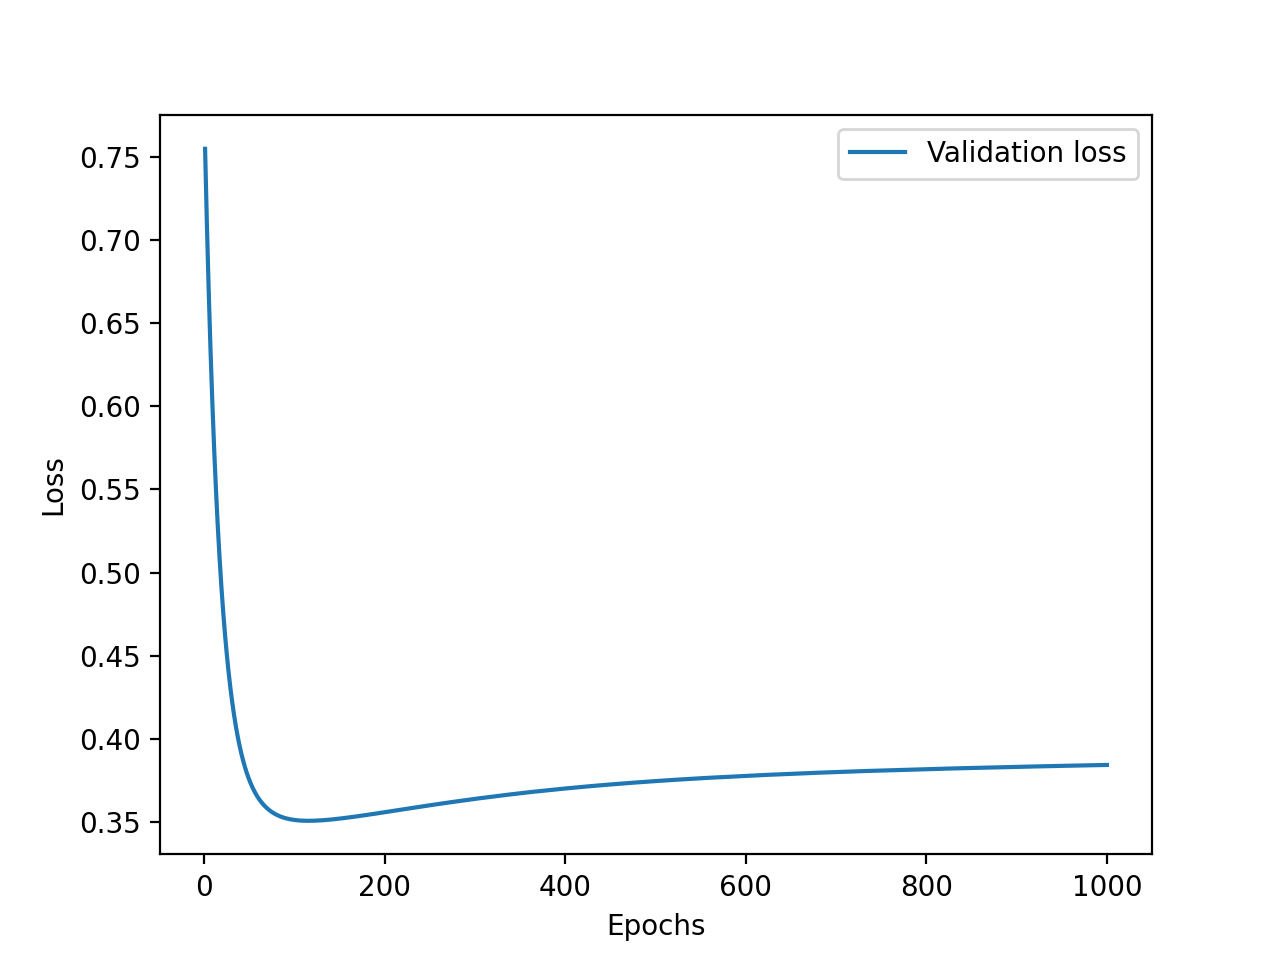

Final results:
Training error:0.271943+-0.022437
Testing error:0.322615+-0.050265


In [15]:
model = Kfold(5,feats,y_encoded,epochs=1000,learning_rate=0.0001,draw_curve=True)

The model is trained and it has a mean squared errror of 0.269 after running the k-fold validation function. Next I use the model to predict survivability based on the first record from the features dataset. I use the encoder object to decode the output from the perceptron to a number either 1 or 0. It seems that the model has worked, but we cannot be sure of the percentage error rate, we just know that the MSE loss function has been minimized and that the model is well trained enough to make a good guess. The testing error is higher which suggests that the model performs less well on new data that was not in the training set, on average.

In [16]:
X = feats[0:5, :]
y_out = model.predict(X)
prediction = output_encoder.inverse_transform(y_out)
print(prediction)

[[1]
 [1]
 [0]
 [1]
 [0]]


Looking at the first five passengers in the dataframe, the model correctly predicts the survival outcome for each one.

In [17]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


# Problem 3
### (A)

Use the generate_data() function to generate 5000 data points and do a kfold validation on with the simple perceptron to estimate the solution to the function 
$$y = 3\sin(x) + 5$$

In [18]:
def generate_X(number):
    xs=(np.random.random(number)*2-1)*10
    return xs
    
def generate_data(number,stochascity=0.05):
    xs=generate_X(number)
    fs=3*np.sin(xs)+5
    stochastic_ratio=(np.random.random(number)*2-1)*stochascity+1
    return xs,fs*stochastic_ratio

In [19]:
x, y = generate_data(5000, stochascity = 0.05)
x = x.reshape(-1, 1)
print('x shape: ', x.shape)
y = y.reshape(-1, 1)
print('y shape: ', y.shape)

x shape:  (5000, 1)
y shape:  (5000, 1)


In [20]:
model = Kfold(5,x,y,epochs=1000,learning_rate=0.0001,draw_curve = False)

Number of epochs with lowest validation: 13
Train error: 4.176451014256818
Test error: 4.14290440305689
Number of epochs with lowest validation: 668
Train error: 4.179636576617911
Test error: 4.120422536419727
Number of epochs with lowest validation: 17
Train error: 4.124066768513443
Test error: 4.331306376629282
Number of epochs with lowest validation: 254
Train error: 4.169583843734897
Test error: 4.162217406199242
Number of epochs with lowest validation: 930
Train error: 4.198369524099093
Test error: 4.1023194336619815
Final results:
Training error:4.169622+-0.024693
Testing error:4.171834+-0.082263


The kfold validation shows that the Mean Squared error is minimized and that the average training error is close to the average test error at 4.14, so the model performs just as well on new data as it does with training data. Next generate 1000 points to use as test data and show the correlation between the output prediction and the true data.

In [21]:
x1, y1 = generate_data(1000, 0.05)
x1 = x1.reshape(-1, 1)
print('x1 shape: ', x1.shape)
#y1 = y1.reshape(-1, 1)
print('y1 shape: ', y1.shape)

x1 shape:  (1000, 1)
y1 shape:  (1000,)


In [22]:
y1_predicted = model.predict(x1)
y1_predicted.shape
y1_predicted = y1_predicted.reshape(len(y1_predicted))
y1_predicted.shape

(1000,)

In [23]:
def show_correlation(xs,ys):
    if len(xs.shape) > 1:
        xs = xs.reshape(-1, 1)
    if len(ys.shape) > 1:
        ys = ys.reshape(-1, 1)
    plt.figure()
    plt.scatter(xs,ys,s=0.5)
    r = [np.min([np.min(xs),np.min(ys)]),np.max([np.max(xs),np.max(ys)])]
    plt.plot(r,r,'r')
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)

<IPython.core.display.Javascript object>


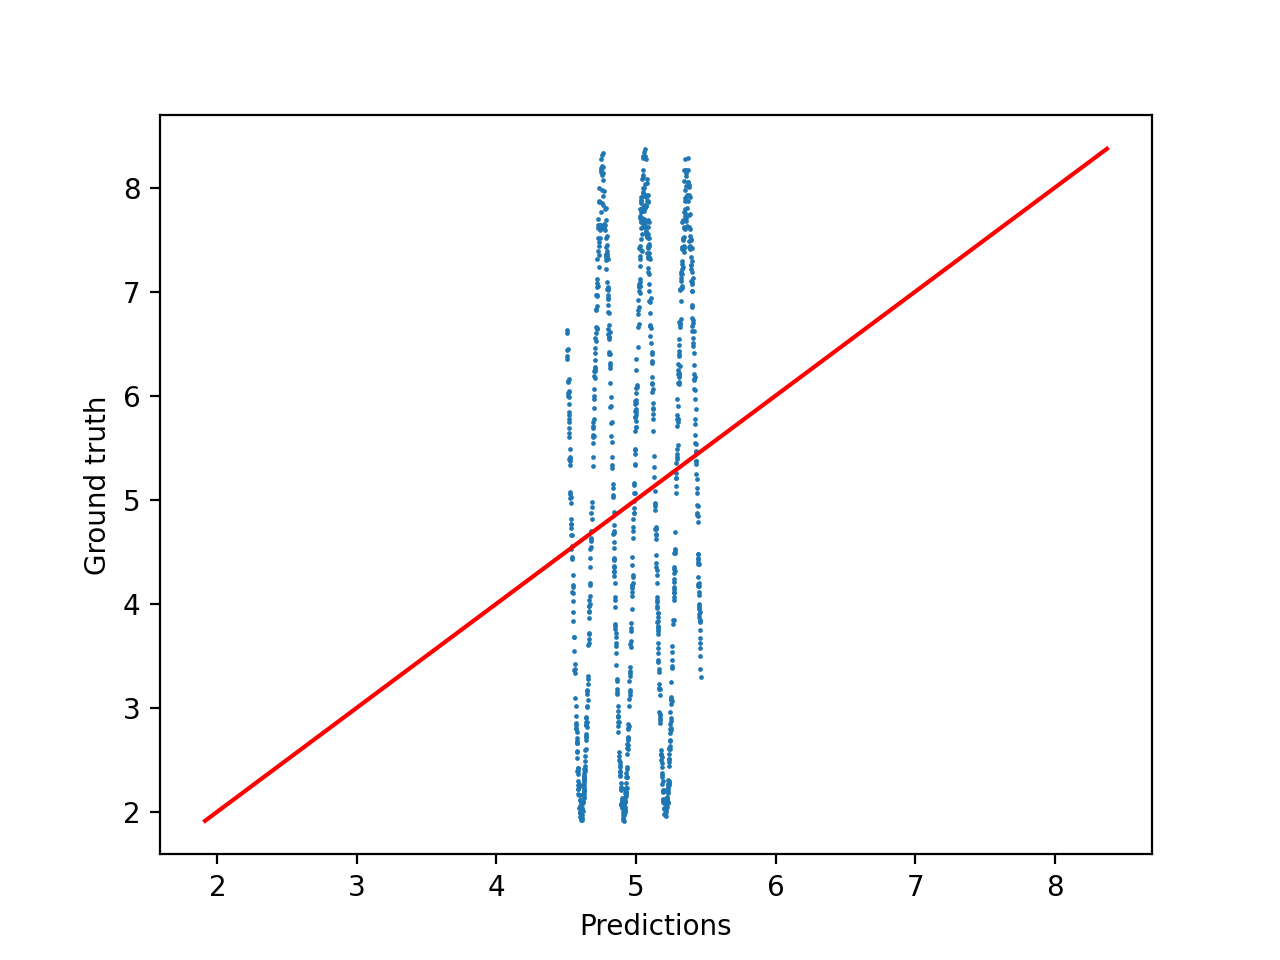

Correlation coefficient: 0.21209256441298924


In [24]:
show_correlation(y1_predicted, y1)

Using the simple perceptron in the kfold algorithm is not sufficient to model the function with one input and one output, because there is only one weight, connecting the input x to the output y, so the prediction of y is just the activation function evaluated at xw + b, which is a linear function. So the prediction is linear in x, which is why the chart of ground truth vs. prediction is a sine curve.

### (B)

Use sklearn to do a k-fold validation of this model using the multilayer perceptron regressor with one hidden layer of 8 nodes.

In [25]:
def KFold_NN(k,Xs,ys,hidden_layers,epochs=1000,lr=0.001):
    # The total number of examples for training the network
    hl = hidden_layers
    total_num=len(Xs)
    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= Xs[train_selector]
        test_Xs=  Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        

        val_array=[]
        # Split training examples further into training and validation
        train_in,val_in,train_real,val_real=train_test_split(train_Xs,train_ys, train_size = 0.8)
        
        model = MLPRegressor(max_iter=epochs, activation='tanh', early_stopping=True, 
                             validation_fraction=0.25, learning_rate='constant', learning_rate_init=lr,
                             hidden_layer_sizes=hl).fit(train_Xs, train_ys)
        

        # Report result for this fold
        train_error=model.fit(train_Xs,train_ys).loss_
        train_error_all.append(train_error)
        test_error= model.fit(test_Xs, test_ys).loss_
        test_error_all.append(test_error)
        print("Train error:",train_error)
        print("Test error:",test_error)
        
            
    print("Final results:")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Testing error:%f+-%f"%(np.average(test_error_all),np.std(test_error_all)))
    
    # return the last model
    return model

In [26]:
x, y = generate_data(5000, 0.05)
x = x.reshape(-1, 1)
print('x shape: ', x.shape)
print('y shape: ', y.shape)
layers = [8]
model = KFold_NN(5,x,y,layers, epochs = 10000, lr = 0.001)

x shape:  (5000, 1)
y shape:  (5000,)
Train error: 1.9846138640257904
Test error: 1.780913583695041
Train error: 0.1640948836596848
Test error: 1.8709610725583485
Train error: 2.0038399836933607
Test error: 0.19855788979988437
Train error: 0.0502913594080198
Test error: 0.23585139152445117
Train error: 0.990975023482501
Test error: 0.8608917776642663
Final results:
Training error:1.038763+-0.845034
Testing error:0.989435+-0.722970


x shape:  (1000, 1)
y shape:  (1000,)


<IPython.core.display.Javascript object>


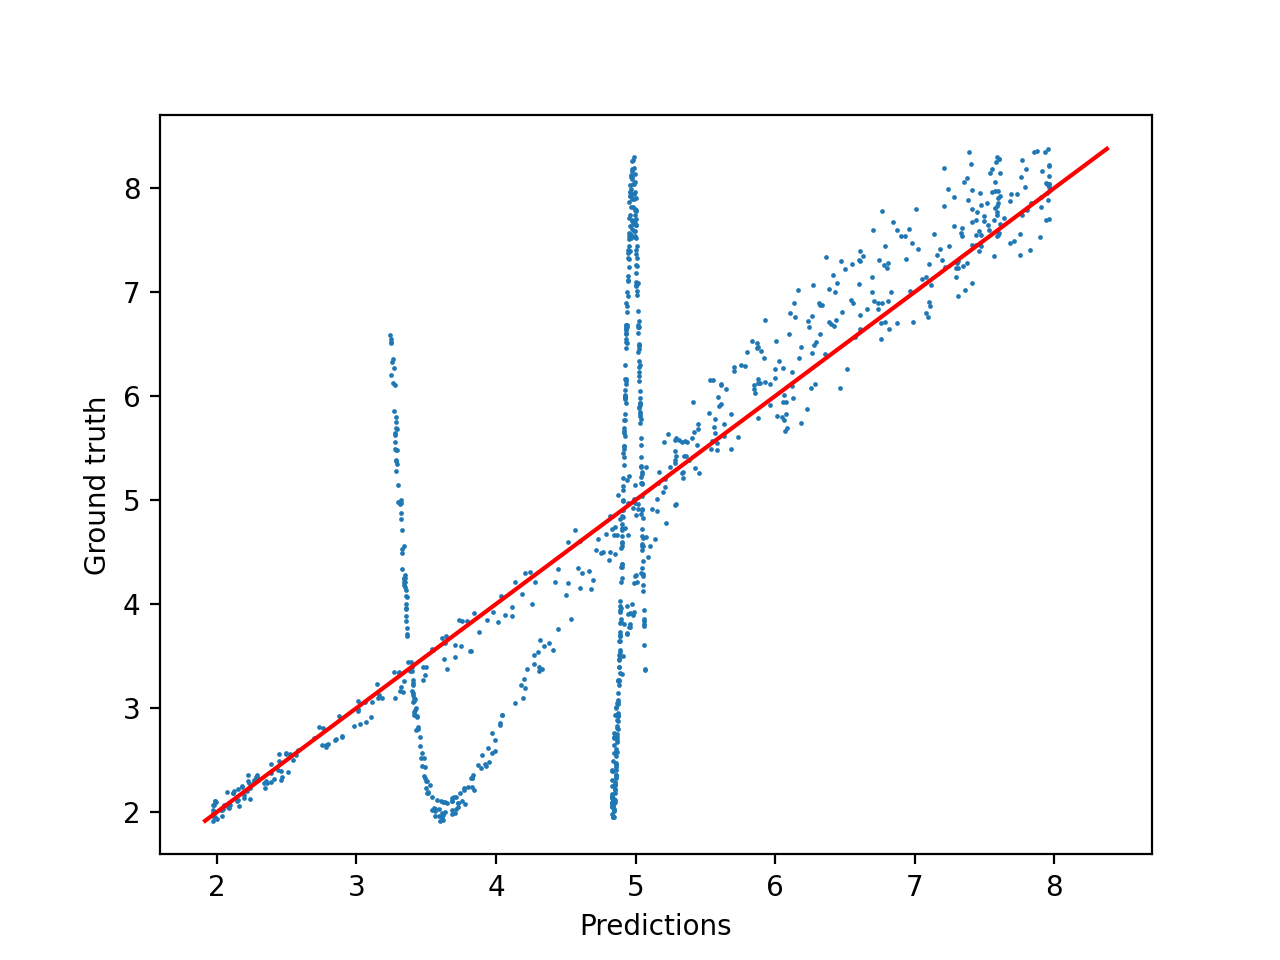

Correlation coefficient: 0.7568867895959448


In [27]:
x, y = generate_data(1000, 0.05)
x = x.reshape(-1, 1)
print('x shape: ', x.shape)
print('y shape: ', y.shape)

y_predicted = model.predict(x)
show_correlation(y_predicted, y)

This time the prediction gets closer to the real values, but it is still not sufficient to model the function with one input and one output, even with the 8 hidden nodes included. The correlation coefficient is only slightly higher than the model with no hidden nodes. This output varies each time I run the notebook, so the model sometimes looks okay but it is not as good a fit as the next example.

### (C)

I added three hidden layers of eight nodes each and used the MLP regressor model to do a k-fold validation and compare it to the model with only one hidden layer.

In [28]:
x, y = generate_data(5000, 0.05)
x = x.reshape(-1, 1)
print('x shape: ', x.shape)
print('y shape: ', y.shape)
layers = [8, 8, 8]
model = KFold_NN(5,x,y,layers, epochs = 10000, lr = 0.001)

x shape:  (5000, 1)
y shape:  (5000,)
Train error: 0.017345428804372207
Test error: 0.029703968120163883
Train error: 0.017488156721756673
Test error: 0.022941338812940516
Train error: 0.01699832559974995
Test error: 0.26624488490168846
Train error: 0.01569074165418169
Test error: 0.2980379071747713
Train error: 0.016941179571608712
Test error: 0.2491182677145297
Final results:
Training error:0.016893+-0.000635
Testing error:0.173209+-0.120975


x shape:  (1000, 1)
y shape:  (1000,)


<IPython.core.display.Javascript object>


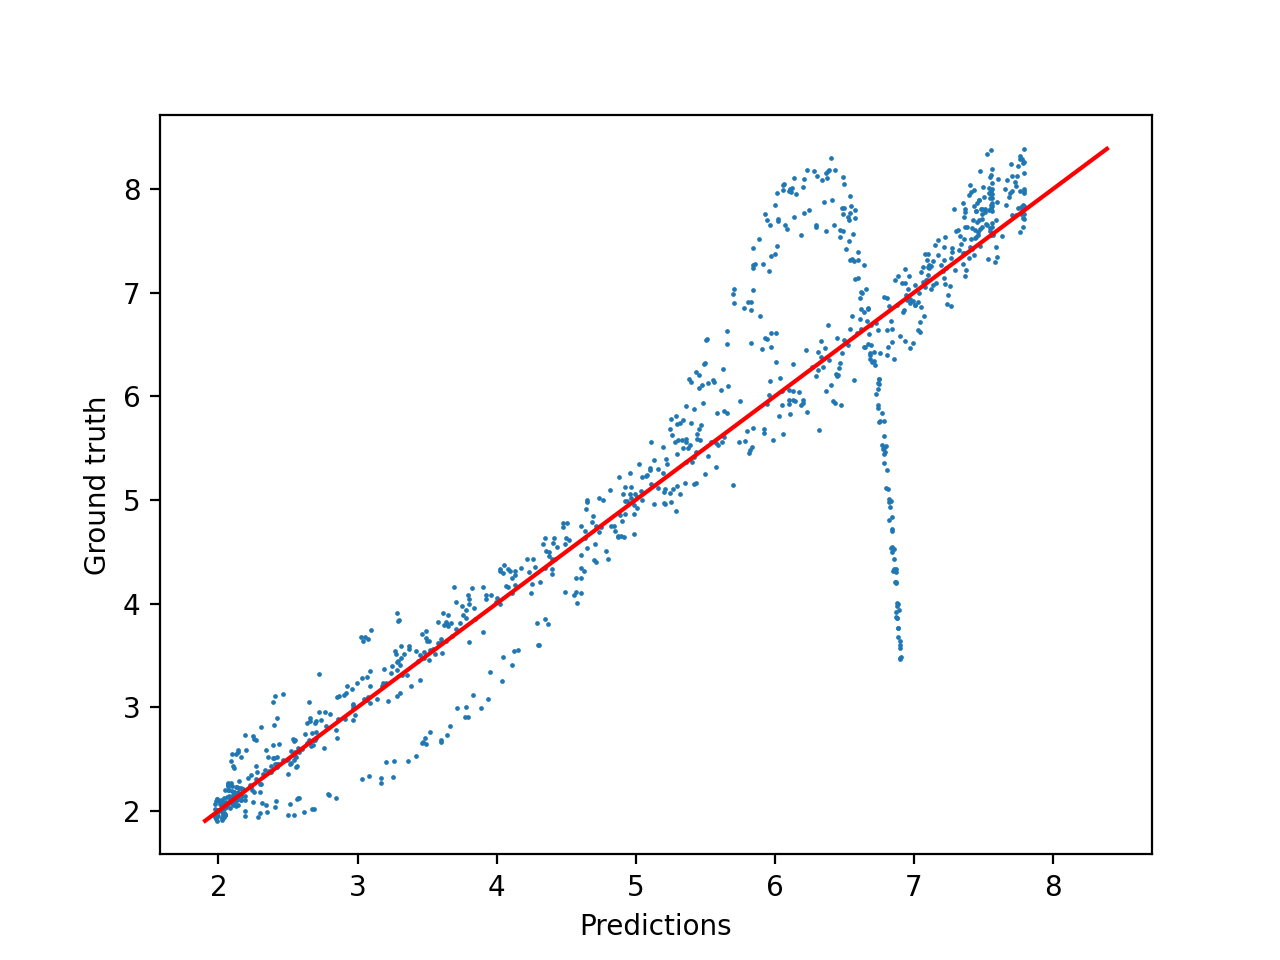

Correlation coefficient: 0.9315220661331506


In [29]:
x, y = generate_data(1000, 0.05)
x = x.reshape(-1, 1)
print('x shape: ', x.shape)
print('y shape: ', y.shape)

y_predicted = model.predict(x)
show_correlation(y_predicted, y)

This model is better because it has three layers of 8 hidden nodes each, which turns out to be more effective in modeling the function with one input and one output. Again this output looks different each time I run the notebook so this may be different depending on the choice for the random seed. I could get a correlation as high as 0.99 by running this model with three hidden layers.